# Residual Layers and Squeeze-and-Excite

This part of the lab is adapted from [kuangliu's PyTorch CIFAR repository on GitHub](https://github.com/kuangliu/pytorch-cifar/blob/master/models/googlenet.py).

In this lab, we will develop ResNets and SE Nets.

## Preliminaries (datasets and data loaders)

Let's follow the same process as in lab 2. We import necessary libraries, load images, and transform them to 3x224x224.
This version is changed a bit to allow different transforms for the training set (augmentation) and val/test sets.

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F

# Set device to GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Allow augmentation transform for training set, no augementation for val/test set

train_preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

eval_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.


full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=True, download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=False, download=True, transform=eval_preprocess)

# DataLoaders for the three datasets

BATCH_SIZE=128
NUM_WORKERS=4

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE,  shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

Files already downloaded and verified
Files already downloaded and verified


## ResNet

The ResNet CNN, which is still very popular as a baseline model today, was first described in [the ResNet paper](https://arxiv.org/pdf/1512.03385.pdf). Prior to ResNet, there were many difficulties building very deep neural networks. First, an ordinary convolutional layer, when it is first initialized with small random weights, basically scrambles its input. Activation functions like sigmoids, hyperbolic tangents, and ReLU quash gradients during backpropagation for patterns with activations falling in the near 0 or 0 region of the activation function. This is called the *vanishing gradient* problem, the effect of which increases with network depth. This problem can be solved with batch normalization and other normalization techniques to allow DNNs trained by SGD to extend to 10's of layers. However, practitioners found other problems that occur when we go beyond 10-20 layers: the problem of *degradation*, in which training error decreases with additional network depth to a point, then starts to *increase*. To address the degredation issue to the point that we can build models with hundreds of layers, the Microsoft Research ResNet team introduced a mechanism for shortcut connections that prevents the scrambling of effect of newly initialized layers by bypassing them, allowing undegraded gradient information to be efficiently backpropagated to the earliest layers of the model.

### ResNet structure

For a 224 $\times$ 224 input, the ResNet structure has four stages/resolutions with a number of residual blocks in each stage. We can describe a ResNet of this type
with a tuple of four numbers $(s_1, s_2, s_3, s_4)$ giving the number of residual blocks in each layer.
For example, ResNet34 can be described as a $(3,4,6,3)$ ResNet.

### ResNet18

On page 5 of [the ResNet paper](https://arxiv.org/pdf/1512.03385.pdf), the simplest ResNet
described is now known as ResNet18. It is a 1.8 GFLOP CNN with $[2,2,2,2]= 8$ residual blocks and two convolutional
layers in each residual block, which along with the initial convolution (7$\times$7 in the paper, 3$\times$3 here)
and the final linear / softmax layer, giving us a total of 18 layers:

<img src="figures/Resnet18_new.png" title="ResNet18" style="width: 1400px;" />

### Residual blocks

The residual block is a reusable block.
ResNet18 and ResNet34 use very basic residual blocks, but
ResNet50, ResNet101, and ResNet152 use more complicated residual blocks
with three convolutions, the middle of which is a
bottleneck that increases the representational power of the block
without an enormous increase in the number of parameters.

We need two types of residual block, one that preserves feature map size and one
that allows changes to the feature map size:

<img src="figures/residualblock_new1.png" title="Residual block" style="width: 800px;" />

Note that only the shape-preserving residual block has a real identity mapping.
The 1x1 strided convolution is the simplest way to allow changes in the input
feature map size, but since the parameters are learned, after training, the result
may be quite different from an identity mapping.

Let's see how to implement a residual block in a resuable way. This
code is modified from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py.

In [2]:
class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### Bottleneck blocks

When we design a residual block for a model with more than 50 layers, ResNet uses bottleneck blocks, whick add another 1$\times$1 CNN layer to the residual network. The use of a bottleneck reduces the number of parameters and matrix multiplications. The idea is to make residual blocks as thin as possible to increase depth with few parameters. 

Here's the bottlneck version with three layers per residual block:

In [26]:
class BottleneckBlock(nn.Module):
    '''
    BottleneckBlock: More powerful residual block with three convs, used for Resnet50 and up
    '''
    EXPANSION = 4
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.EXPANSION * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.EXPANSION * planes)

        self.shortcut = nn.Sequential()
        # If the output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != self.EXPANSION * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.EXPANSION * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

### Resnet

Here is the whole shebang for ResNet, with the layer sizes tailored a bit to our input size of 64x64:

In [27]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

From this template we can make various ResNets:

In [28]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


def ResNet34(num_classes):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of two convolutions each: 3*2 + 4*2 + 6*2 + 3*2 = 32
    last FC layer: 1
    Total layers: 1+32+1 = 34
    '''
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


def ResNet50(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 6, 3] sets of three convolutions each: 3*3 + 4*3 + 6*3 + 3*3 = 48
    last FC layer: 1
    Total layers: 1+48+1 = 50
    '''
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


def ResNet101(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 4, 23, 3] sets of three convolutions each: 3*3 + 4*3 + 23*3 + 3*3 = 99
    last FC layer: 1
    Total layers: 1+99+1 = 101
    '''
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


def ResNet152(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with [3, 8, 36, 3] sets of three convolutions each: 3*3 + 8*3 + 36*3 + 3*3 = 150
    last FC layer: 1
    Total layers: 1+150+1 = 152
    '''
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

OK, let's test it! Here's a `train_model()` function again:

In [31]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model: train a model on a dataset
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        # print('outputs', outputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

The train function still be the same as lab2. Then, you can train Resnet function.

In [32]:
resnet = ResNet18().to(device)
# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)

best_model, val_acc_history, loss_acc_history = train_model(resnet, dataloaders, criterion, optimizer, 25, 'resnet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.7999 Acc: 0.3467
Epoch time taken:  16.710540056228638
val Loss: 1.4466 Acc: 0.4670
Epoch time taken:  17.87187957763672

Epoch 1/24
----------
train Loss: 1.2981 Acc: 0.5263
Epoch time taken:  15.53918981552124
val Loss: 1.2893 Acc: 0.5481
Epoch time taken:  16.704119443893433

Epoch 2/24
----------
train Loss: 1.0050 Acc: 0.6434
Epoch time taken:  15.592320442199707
val Loss: 1.0072 Acc: 0.6488
Epoch time taken:  16.75678038597107

Epoch 3/24
----------
train Loss: 0.8197 Acc: 0.7103
Epoch time taken:  15.62535572052002
val Loss: 0.8911 Acc: 0.6943
Epoch time taken:  16.794168949127197

Epoch 4/24
----------
train Loss: 0.6920 Acc: 0.7554
Epoch time taken:  15.689477682113647
val Loss: 0.8134 Acc: 0.7176
Epoch time taken:  16.85688614845276

Epoch 5/24
----------
train Loss: 0.5740 Acc: 0.7998
Epoch time taken:  15.68758487701416
val Loss: 0.6820 Acc: 0.7608
Epoch time taken:  16.854762315750122

Epoch 6/24
----------
train Loss: 0.4837 Acc: 0.8312

## Squeeze and Excite networks

Squeeze and Excite networks (SENet) is a building block for CNNs that improves channel interdependencies at almost no computational cost. The modification from the ordinary ResNet is easy. The main idea of SENet is add parameters in each channel, then the network can adaptively adjust the weighting of each feature map.

SENets are all about changing this by adding a content aware mechanism to weight each channel adaptively. In it’s most basic form this could mean adding a single parameter to each channel and giving it a linear scalar how relevant each one is.

The concept of squeeze and excite (SENet) is shown here:

<img src="figures/SEInceptionModule.PNG" title="se block" style="width: 800px;" />

<img src="figures/SEResnetModule.PNG" title="se block" style="width: 800px;" />

Implementation is beautifully simple. Here's an example of an SE module
from https://github.com/moskomule/senet.pytorch/blob/23839e07525f9f5d39982140fccc8b925fe4dee9/senet/se_module.py#L4:

In [33]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

SE modules can be added anywhere you like:

<img src="figures/SEblockSet.PNG" title="se add" style="width: 800px;" />

Let's use the standard option (option b above) recommended by the authors:

In [36]:
class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)


Let's try the SE version of ResNet18 and compare in terms of time and accuracy.

In [37]:
ressenet = ResSENet18().to(device)
# Optimizer, loss function
criterion2 = nn.CrossEntropyLoss()
params_to_update2 = ressenet.parameters()
optimizer2 = optim.Adam(params_to_update2, lr=0.01)

best_model2, val_acc_history2, loss_acc_history2 = train_model(ressenet, dataloaders, criterion2, optimizer2, 25, 'ressenet18_bestsofar')

Epoch 0/24
----------
train Loss: 1.6601 Acc: 0.3943
Epoch time taken:  16.438998460769653
val Loss: 1.5623 Acc: 0.4578
Epoch time taken:  17.690410137176514

Epoch 1/24
----------
train Loss: 1.1759 Acc: 0.5739
Epoch time taken:  16.531738758087158
val Loss: 1.1455 Acc: 0.5960
Epoch time taken:  17.772821187973022

Epoch 2/24
----------
train Loss: 0.8912 Acc: 0.6826
Epoch time taken:  16.583104133605957
val Loss: 0.8534 Acc: 0.7013
Epoch time taken:  17.81159782409668

Epoch 3/24
----------
train Loss: 0.7227 Acc: 0.7437
Epoch time taken:  16.642486095428467
val Loss: 0.7746 Acc: 0.7285
Epoch time taken:  17.898549556732178

Epoch 4/24
----------
train Loss: 0.5810 Acc: 0.7960
Epoch time taken:  16.65541696548462
val Loss: 0.7179 Acc: 0.7554
Epoch time taken:  17.905095100402832

Epoch 5/24
----------
train Loss: 0.4845 Acc: 0.8307
Epoch time taken:  16.68896198272705
val Loss: 0.5706 Acc: 0.8052
Epoch time taken:  17.91822099685669

Epoch 6/24
----------
train Loss: 0.4119 Acc: 0.85

In [38]:
import matplotlib.pyplot as plt

def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'ResNet18')
    plt.plot(loss_acc_history2, label = 'ResSENet18')
    plt.title('Training loss over time')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'ResNet18')
    plt.plot(val_acc_history2, label = 'ResSENet18')
    plt.title('Validation accuracy over time')
    plt.legend()
    plt.show()

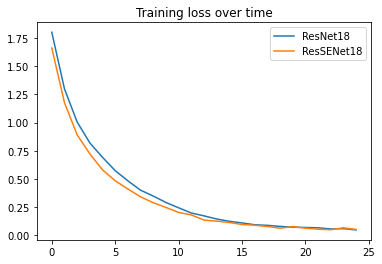

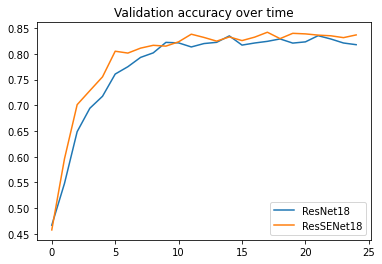

In [39]:
plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2)